In [480]:
# import packages
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime
from functools import partial
import sys 
import os
import statsmodels.api as sm
import warnings
from scipy.optimize import fsolve, minimize
import myfunctions #from package


In [481]:
# Question 1

In [482]:
current_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15)
T = (expire_date - current_date).days / 365

S = 151.03
X = 165
sigma = 0.2

r = 0.0425
coupon = 0.0053
b = r - coupon

In [483]:
def calculate_d1(S, X, T, sigma, b):
    return (np.log(S / X) + (b + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

def calculate_d2(d1, T, sigma):
    return d1 - sigma * np.sqrt(T)

In [484]:
def bsm_delta(option_type, S, X, T, sigma, r, b):
    """Calculate the delta of an option."""
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    delta = norm.cdf(d1 * is_call) * is_call
    return delta

def bsm_gamma(option_type, S, X, T, sigma, r, b):
    """Calculate the gamma of an option."""
    d1 = calculate_d1(S, X, T, sigma, b)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

def bsm_vega(option_type, S, X, T, sigma, r, b):
    """Calculate the vega of an option."""
    d1 = calculate_d1(S, X, T, sigma, b)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

def bsm_theta(option_type, S, X, T, sigma, r, b):
    """Calculate the theta of an option."""
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    theta = (-S * np.exp((b - r) * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             - (b - r) * S * np.exp((b - r) * T) * norm.cdf(d1 * is_call) * is_call
             - r * X * np.exp(-r * T) * norm.cdf(d2 * is_call) * is_call)
    return theta

def bsm_rho(option_type, S, X, T, sigma, r, b):
    """Calculate the rho of an option."""
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    rho = X * T * np.exp(-r * T) * norm.cdf(d2 * is_call) * is_call
    return rho

def bsm_carry_rho(option_type, S, X, T, sigma, r, b):
    """Calculate the carry rho of an option."""
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    carry_rho = S * T * np.exp((b - r) * T) * norm.cdf(d1 * is_call) * is_call
    return carry_rho

In [485]:
import inspect

# calculate first order derivative
def first_order_der(func, x, delta):
    return (func(x + delta) - func(x - delta)) / (2 * delta)

# calculate second order derivative
def second_order_der(func, x, delta):
    return (func(x + delta) + func(x - delta) - 2 * func(x)) / delta ** 2

def cal_partial_derivative(func, order, arg_name, delta=1e-3):
    # initialize for argument names and order
    arg_names = list(inspect.signature(func).parameters.keys())
    derivative_fs = {1: first_order_der, 2: second_order_der}

    def partial_derivative(*args, **kwargs):
        # parse argument names and order
        args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
        arg_val = args_dict.pop(arg_name)

        def partial_f(x):
            p_kwargs = {arg_name:x, **args_dict}
            return func(**p_kwargs)
        return derivative_fs[order](partial_f, arg_val, delta)
    return partial_derivative

In [486]:
def bsm(option_type, S, X, T, sigma, r, b):
    '''
    option_type: call or put
    S: Underlying price
    X: Strike price
    T: Time to maturity
    sigma: Implied volatility
    r: Risk free rate
    b: Cost of carry
    '''
    d1 = (np.log(S / X) + (b + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    is_call = 1 if option_type == "Call" else -1

    res = is_call * (S * np.e ** ((b - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
    
    return res

In [487]:
# delta
delta_call = bsm_delta("Call", S, X, T, sigma, r, b)
delta_put = bsm_delta("Put", S, X, T, sigma, r, b)
gbsm_delta_num = cal_partial_derivative(bsm, 1, 'S')
delta_call_num = gbsm_delta_num("Call", S, X, T, sigma, r, b)
delta_put_num = gbsm_delta_num("Put", S, X, T, sigma, r, b)
print(delta_call, delta_put)
print(delta_call_num, delta_put_num)

0.08301107089626869 -0.9169889291037313
0.08297130374668171 -0.9165496329472944


In [488]:
# gamma
gamma_call = bsm_gamma("Call", S, X, T, sigma, r, b)
gamma_put = bsm_gamma("Put", S, X, T, sigma, r, b)
gbsm_gamma_num = cal_partial_derivative(bsm, 2, 'S')
gamma_call_num = gbsm_gamma_num("Call", S, X, T, sigma, r, b)
gamma_put_num = gbsm_gamma_num("Put", S, X, T, sigma, r, b)
print(gamma_call, gamma_put)
print(gamma_call_num, gamma_put_num)

0.016830979206204362 0.016830979206204362
0.016822911064195978 0.016822951920403284


In [489]:
# vega
vega_call = bsm_vega("Call", S, X, T, sigma, r, b)
vega_put = bsm_vega("Put", S, X, T, sigma, r, b)
gbsm_vega_num = cal_partial_derivative(bsm, 1, 'sigma')
vega_call_num = gbsm_vega_num("Call", S, X, T, sigma, r, b)
vega_put_num = gbsm_vega_num("Put", S, X, T, sigma, r, b)
print(vega_call, vega_put)
print(vega_call_num, vega_put_num)

6.942036604441163 6.942036604441163
6.938653056250743 6.93865305626673


In [490]:
# theta
theta_call = bsm_theta("Call", S, X, T, sigma, r, b)
theta_put = bsm_theta("Put", S, X, T, sigma, r, b)
gbsm_theta_num = cal_partial_derivative(bsm, 1, 'T')
theta_call_num = -gbsm_theta_num("Call", S, X, T, sigma, r, b)
theta_put_num = -gbsm_theta_num("Put", S, X, T, sigma, r, b)
print(theta_call, theta_put)
print(theta_call_num, theta_put_num)

-8.126522359668838 -1.9409914783019566
-8.126308803761084 -1.9407779203106656


In [491]:
# rho
rho_call = bsm_rho("Call", S, X, T, sigma, r, b)
rho_put = bsm_rho("Put", S, X, T, sigma, r, b)
gbsm_rho_num = cal_partial_derivative(bsm, 1, 'r')
rho_call_num = gbsm_rho_num("Call", S, X, T, sigma, r, b)
rho_put_num = gbsm_rho_num("Put", S, X, T, sigma, r, b)
print(rho_call, rho_put)
print(rho_call_num, rho_put_num)

1.1025939156368187 -13.758003122735788
-0.030359909416688424 -1.2427313238703164


In [492]:
# carry rho
carry_rho_call = bsm_carry_rho("Call", S, X, T, sigma, r, b)
carry_rho_put = bsm_carry_rho("Put", S, X, T, sigma, r, b)
gbsm_carry_rho_num = cal_partial_derivative(bsm, 1, 'b')
carry_rho_call_num = gbsm_carry_rho_num("Call", S, X, T, sigma, r, b)
carry_rho_put_num = gbsm_carry_rho_num("Put", S, X, T, sigma, r, b)
print(carry_rho_call, carry_rho_put)
print(carry_rho_call_num, carry_rho_put_num)

1.132953825011723 -12.515271800549371
1.1329550097096686 -12.515270634423814


In [493]:
def n_nodes(N):
    return (N + 2) * (N + 1) // 2

def node_index(i, j):
    return n_nodes(j - 1) + i

def binomial_tree_no_div(option_type, S0, X, T, sigma, r, N):
    is_call = 1 if option_type == "Call" else -1
    dt = T / N
    disc = np.exp(-r * dt)
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    C = np.empty(n_nodes(N), dtype=float)
            
    for i in np.arange(N, -1, -1):
        for j in range(i, -1, -1):
            S = S0 * u ** j * d ** (i - j)
            index = node_index(j, i)
            C[index] = max(0, (S - X) * is_call)
            if i < N:
                val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
                C[index] = max(C[index], val)
                
    return C[0]

def binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N):
    if div_date is None or div is None:
        return binomial_tree_no_div(option_type, S0, X, T, sigma, r, N)
  
    is_call = 1 if option_type == "Call" else -1
    dt = T / N
    disc = np.exp(-r * dt)
    
    #calculate u, d, and p
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
 
    new_T = T - div_time * dt
    new_N = N - div_time

    C = np.empty(n_nodes(div_time), dtype=float)
    for i in range(div_time, -1, -1):
        for j in range(i, -1, -1):
            S = S0 * u ** j * d ** (i - j)
            val_exe = max(0, (S - X) * is_call)
            if i < div_time:
                val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
            else:
                val = binomial_tree(option_type, S - div, X, new_T, None, None, sigma, r, new_N)
            C[node_index(j, i)] = max(val_exe, val)
    
    return C[0]

In [494]:
# Assume N is 200
N = 200
value_no_div_call = binomial_tree_no_div("Call", S, X, T, sigma, r, N)
value_no_div_put = binomial_tree_no_div("Put", S, X, T, sigma, r, N)
print("Binomial tree value without dividend for call: " + str(value_no_div_call))
print("Binomial tree value without dividend for put: " + str(value_no_div_put))

Binomial tree value without dividend for call: 0.3420415058233237
Binomial tree value without dividend for put: 14.02022659787544


In [495]:
div_date = datetime(2022, 4, 11)
div = 0.88
div_time = int((div_date - current_date).days / (expire_date - current_date).days * N)

value_call = binomial_tree("Call", S, X, T, div_time, div, sigma, r, N)
value_put = binomial_tree("Put", S, X, T, div_time, div, sigma, r, N)
print("Binomial tree value with dividend for call: " + str(value_call))
print("Binomial tree value with dividend for put: " + str(value_put))

Binomial tree value with dividend for call: 0.2981599372927687
Binomial tree value with dividend for put: 14.55911431446306


In [496]:
# delta
cal_amr_delta_num = cal_partial_derivative(binomial_tree, 1, 'S0')
delta_call_amr = cal_amr_delta_num("Call", S, X, T, div_time, div, sigma, r, N)
delta_put_amr = cal_amr_delta_num("Put", S, X, T, div_time, div, sigma, r, N)
print(delta_call_amr, delta_put_amr)

0.0694035170404339 -0.9384266902472405


In [497]:
# gamma
cal_amr_gamma_num = cal_partial_derivative(binomial_tree, 2, 'S0', delta=1)
gamma_call_amr = cal_amr_gamma_num("Call", S, X, T, div_time, div, sigma, r, N)
gamma_put_amr = cal_amr_gamma_num("Put", S, X, T, div_time, div, sigma, r, N)
print(gamma_call_amr, gamma_put_amr)

0.0188730869562459 0.017693002005984226


In [498]:
# vega
cal_amr_vega_num = cal_partial_derivative(binomial_tree, 1, 'sigma')
vega_call_amr = cal_amr_vega_num("Call", S, X, T, div_time, div, sigma, r, N)
vega_put_amr = cal_amr_vega_num("Put", S, X, T, div_time, div, sigma, r, N)
print(vega_call_amr, vega_put_amr)

6.143196715376997 5.664125621646754


In [499]:
# theta
cal_amr_theta_num = cal_partial_derivative(binomial_tree, 1, 'T')
theta_call_amr = -cal_amr_theta_num("Call", S, X, T, div_time, div, sigma, r, N)
theta_put_amr = -cal_amr_theta_num("Put", S, X, T, div_time, div, sigma, r, N)
print(theta_call_amr, theta_put_amr)

-7.2765273123804315 -0.46564521876213405


In [500]:
# rho
cal_amr_rho_num = cal_partial_derivative(binomial_tree, 1, 'r')
rho_call_amr = cal_amr_rho_num("Call", S, X, T, div_time, div, sigma, r, N)
rho_put_amr = cal_amr_rho_num("Put", S, X, T, div_time, div, sigma, r, N)
print(rho_call_amr, rho_put_amr)

0.9426794754235357 -12.407586180172459


In [501]:
delta = 1e-3
call_value1 = binomial_tree("Call", S, X, T, div_time, div + delta, sigma, r, N)    
call_value2 = binomial_tree("Call", S, X, T, div_time, div - delta, sigma, r, N)    
call_sens_to_div_amount = (call_value1 - call_value2) / (2*delta)

put_value1 = binomial_tree("Put", S, X, T, div_time, div + delta, sigma, r, N)    
put_value2 = binomial_tree("Put", S, X, T, div_time, div - delta, sigma, r, N)    
put_sens_to_div_amount = (put_value1 - put_value2) / (2*delta)
print(f"Sensitivity to dividend amount: Call: {call_sens_to_div_amount:.3f}, Put: {put_sens_to_div_amount:.3f}")

Sensitivity to dividend amount: Call: -0.025, Put: 0.941


In [502]:
# Question 2

In [503]:
def implied_vol_american(option_type, S0, X, T, div_time, div, r, N, market_price, x0=0.5):
    def equation(sigma):
        return binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N) - market_price
    # Back solve the binomial tree valuation to get the implied volatility
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)
    for i in portfolios.index:
        if portfolios["Type"][i] == "Stock":
            # For stock, the single value is its price
            single_values = sim_prices
        else:
            # For option, calculate values with gbsm method
            option_type = portfolios["OptionType"][i]
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
            sigma = portfolios["ImpliedVol"][i]
            div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
            div = 1
            option_values = []
            for S in sim_prices:
                option_values.append(binomial_tree(option_type, S, X, T, div_time, div, sigma, r, N))
            single_values = np.array(option_values)
    
        # Calculate the total values based on holding
        sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
    # Combine the values for same portfolios
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

In [504]:
portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
    if portfolios["Type"][i] == "Stock":
        implied_vols.append(None)
    else:
        option_type = portfolios["OptionType"][i]
        X = portfolios["Strike"][i]
        T = (portfolios["ExpirationDate"][i] - current_date).days / 365
        div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
        market_price = portfolios["CurrentPrice"][i]
        sigma = implied_vol_american(option_type, S, X, T, div_time, div, r, N, market_price)
        implied_vols.append(sigma)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

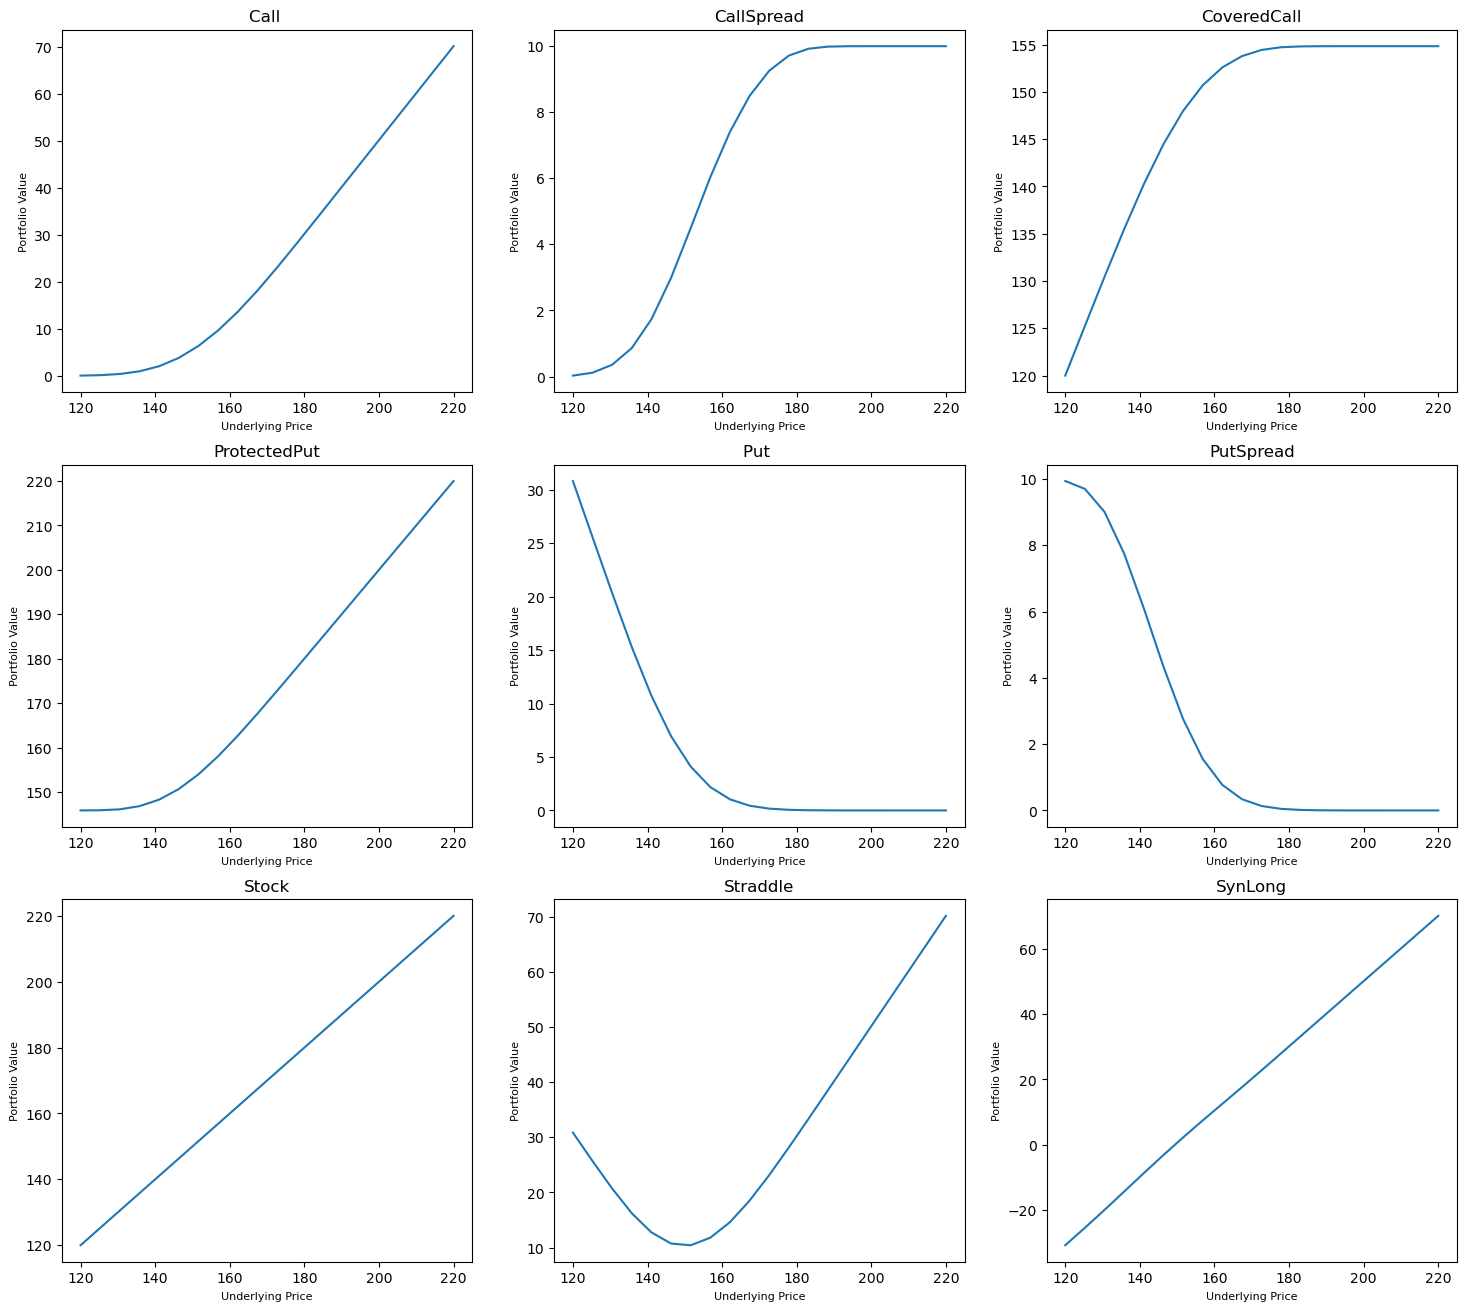

In [505]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 20)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

In [506]:
# Fit Normal and calculate Mean, VaR and ES.
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

daily_prices = pd.read_csv("DailyPrices.csv")
# Assume log return as last week
log_returns = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1)).dropna()
demeaned_returns = log_returns - np.mean(log_returns)

# Simulate the prices based on returns with normal distribution
std = demeaned_returns.std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 100))
sim_prices = 151.03 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result = pd.DataFrame(index=sim_value_changes.index)
result['Mean'] = sim_value_changes.mean(axis=1)
result['VaR'] = sim_value_changes.apply(lambda x:myfunctions.calculate_var(x, 0), axis=1)
result['ES'] = sim_value_changes.apply(lambda x:myfunctions.calculate_es(x), axis=1)
result

,Mean,VaR,ES
Portfolio,,,
Call,-0.127644,6.199831,6.562053
CallSpread,-0.525824,4.029122,4.361915
CoveredCall,-1.731967,13.914309,18.791813
ProtectedPut,0.042517,7.650810,8.040817
Put,1.952323,4.355154,4.649564
PutSpread,0.818268,2.627620,2.853856
Stock,-1.509956,17.804164,22.788306
Straddle,1.824678,1.348182,1.385833
SynLong,-2.079967,19.074750,24.324425


In [507]:
# Calculate VaR and ES using Delta-Normal.
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

cal_amr_delta_num =  cal_partial_derivative(binomial_tree, 1, 'S0')

# Calculate the implied volatility for all portfolios
deltas = []
for i in range(len(portfolios.index)):
    if portfolios["Type"][i] == "Stock":
        deltas.append(1)
    else:
        option_type = portfolios["OptionType"][i]
        X = portfolios["Strike"][i]
        T = ((portfolios["ExpirationDate"][i] - current_date).days - 10) / 365
        div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
        delta = cal_amr_delta_num(option_type, S, X, T, div_time, div, sigma, r, N)
        deltas.append(delta)

# Store the deltas in portfolios
portfolios["deltas"] = deltas

alpha = 0.05
t = 10
result_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['Mean', 'VaR', 'ES'])
result_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
    gradient = S / df['CurrentValue'].sum() * (df['Holding'] * df['deltas']).sum()
    pfl_10d_std = abs(gradient) * std * np.sqrt(t)
    N = scipy.stats.norm(0, 1)
    present_value = df['CurrentValue'].sum() 
    result_dn.loc[pfl]['Mean'] = 0
    result_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
    result_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha

result_dn

,Mean,VaR,ES
Portfolio,,,
Call,0,9.514631,11.931731
CallSpread,0,5.260949,6.597442
CoveredCall,0,10.895474,13.663364
ProtectedPut,0,12.13468,15.217378
Put,0,8.183037,10.261858
PutSpread,0,4.91428,6.162705
Stock,0,17.61745,22.092993
Straddle,0,1.331594,1.669873
SynLong,0,17.697668,22.193589


In [508]:
# Compare these results to last week’s results.
def calculate_sim_values_week6(portfolios, sim_prices, days_ahead=0):
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)
    for i in portfolios.index: 
        if portfolios["Type"][i] == "Stock":
            # For stock, the single value is its price
            single_values = sim_prices
        else:
            # For option, calculate values with gbsm method
            option_type = portfolios["OptionType"][i]
            S = sim_prices
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
            sigma = portfolios["ImpliedVol"][i]
            option_values = bsm(option_type, S, X, T, sigma, r, b)
            single_values = option_values
    
        # Calculate the total values based on holding
        sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
    # Combine the values for same portfolios
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

daily_prices = pd.read_csv("DailyPrices.csv")
#log return calculation
log_returns = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1)).dropna()
demeaned_returns = log_returns - np.mean(log_returns)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(demeaned_returns, order=(1,0,0)).fit()

n_forecast = 10
sim = 1000
phi = model.params[1]
beta = model.params[0]
sigma = model.resid.std()

# Generate the simulated returns
simulated_returns = np.zeros((n_forecast,sim))
np.random.seed(0)
for j in range(sim):
    simulated_returns[0,j]= beta + phi * demeaned_returns.iloc[-1] + sigma * norm.rvs()
    for i in range(n_forecast-1):
        simulated_returns[i+1,j] = beta + phi * simulated_returns[i,j] + sigma * norm.rvs()
        
price_series = pd.DataFrame(daily_prices['AAPL'].iloc[-1] * np.exp(simulated_returns.cumsum(axis=0)))
sim_prices = price_series.loc[9:].values[0]

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result_week6 = pd.DataFrame(index=sim_value_changes.index)
result_week6['Mean'] = sim_value_changes.mean(axis=1)
result_week6['VaR'] = sim_value_changes.apply(lambda x:myfunctions.calculate_var(x, 0), axis=1)
result_week6['ES'] = sim_value_changes.apply(lambda x:myfunctions.calculate_es(x), axis=1)
print(result_week6)

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\11692\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\11692\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                  Mean        VaR         ES
Portfolio                                   
Call          0.106618   6.033670   6.370830
CallSpread   -0.334076   3.874866   4.184882
CoveredCall  -0.956813  12.718575  16.242387
ProtectedPut  0.370352   7.496637   7.845839
Put           1.243079   4.345846   4.590085
PutSpread     0.536272   2.619961   2.807518
Stock        -0.612572  16.550084  20.183831
Straddle      1.349697   1.372482   1.391239
SynLong      -1.136461  17.709756  21.576560


Text(0.5, 1.0, 'ES Comparison')

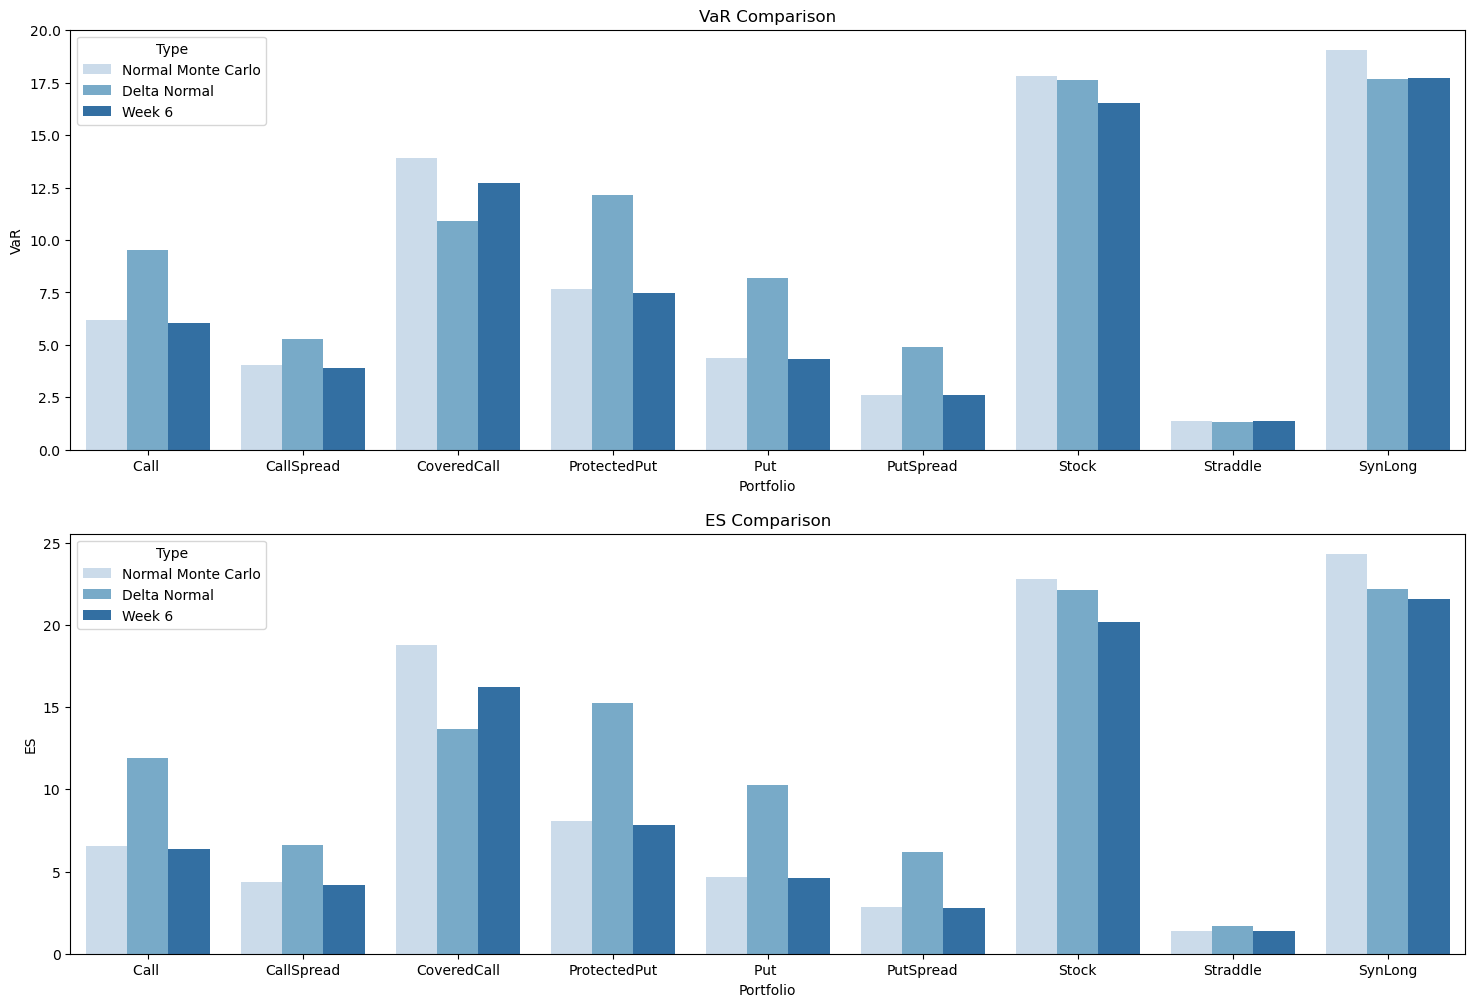

In [509]:
result_dfs = []
for category, result_df in zip(['Normal Monte Carlo', 'Delta Normal', 'Week 6'], [result, result_dn, result_week6]):
    new_result_df = result_df.reset_index()
    new_result_df['Type'] = category
    result_dfs.append(new_result_df)
result_dfs = pd.concat(result_dfs, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
ax = sns.barplot(x='Portfolio', y='VaR', hue='Type', palette='Blues', data=result_dfs, ax=axes[0])
ax.set_title('VaR Comparison')

ax = sns.barplot(x='Portfolio', y='ES', hue='Type', palette='Blues', data=result_dfs, ax=axes[1])
ax.set_title('ES Comparison')

In [510]:
# Question 3

In [511]:
def return_calculate(prices, method="DISCRETE", dateColumn="Date"):
    """Calculate returns of financial instruments in a DataFrame based on a specified method."""

    # Filter out the date column and check its existence
    vars_ = [var for var in prices.columns if var != dateColumn]
    if len(vars_) == len(prices.columns):
        raise ValueError(f"dateColumn: {dateColumn} not found in DataFrame columns.")

    # Convert prices to a NumPy array for efficient computation
    p = prices[vars_].to_numpy()
    n, m = p.shape

    # Calculate returns using vectorized operations
    p2 = p[1:] / p[:-1]
    if method.upper() == "DISCRETE":
        p2 -= 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"Invalid method: {method}. Must be 'LOG' or 'DISCRETE'.")

    # Prepare the output DataFrame
    dates = prices[dateColumn].iloc[1:].to_numpy()
    out = pd.DataFrame({dateColumn: dates}, index=prices.index[1:])
    for i, var in enumerate(vars_):
        out[var] = p2[:, i]

    return out

In [512]:
def pd_return_calculate(series, method="arithmetic"):
    price_change_percent = ((series.shift(-1) - series) / series)
    if method == "arithmetic":
        return price_change_percent
    elif method == "log":
        return np.log(price_change_percent)

In [513]:
research = pd.read_csv('F-F_Research_Data_Factors_daily.csv', parse_dates=['Date']).set_index('Date')
momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv', parse_dates=['Date']).set_index('Date').rename(columns={'Mom   ':  "Mom"})

factor = (research.join(momentum, how='right') / 100).loc['2013-1-31':]
prices = pd.read_csv('DailyPrices.csv', parse_dates=['Date'])
all_returns = pd.DataFrame(return_calculate(prices)).set_index('Date')
stocks = ['AAPL', 'META', 'UNH', 'MA',  
          'MSFT' ,'NVDA', 'HD', 'PFE',  
          'AMZN' ,'BRK-B', 'PG', 'XOM',  
          'TSLA' ,'JPM' ,'V', 'DIS',  
          'GOOGL', 'JNJ', 'BAC', 'CSCO']
factors = ['Mkt-RF', 'SMB', 'HML', 'Mom']
dataset = all_returns[stocks].join(factor)

subset = dataset.dropna()

C:\Users\11692\AppData\Local\Temp\ipykernel_18436\3596555358.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[var] = p2[:, i]


In [514]:
X = subset[factors]
X = sm.add_constant(X)
y = subset[stocks].sub(subset['RF'], axis=0)

betas = pd.DataFrame(index=stocks, columns=factors)
alphas = pd.DataFrame(index=stocks, columns=['Alpha'])

for stock in stocks:
    model = sm.OLS(y[stock], X).fit()
    betas.loc[stock] = model.params[factors]
    alphas.loc[stock] = model.params['const']

sub_return = pd.DataFrame(np.dot(factor[factors],betas.T), index=factor.index, columns=betas.index)
merge_return = pd.merge(sub_return,factor['RF'], left_index=True, right_index=True)
daily_expected_returns = merge_return.add(merge_return['RF'],axis=0).drop('RF',axis=1).add(alphas.T.loc['Alpha'], axis=1)
expected_annual_return = ((daily_expected_returns+1).cumprod().tail(1) ** (1/daily_expected_returns.shape[0]) - 1) * 252
expected_annual_return

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
Date,,,,,,,,,,,,,,,,,,,,
2023-01-31,0.157144,0.017941,0.2538,0.222901,0.155944,0.279721,0.120591,0.076962,-0.042945,0.129923,0.08154,0.521821,-0.033253,0.098273,0.241054,-0.155372,-0.017075,0.124206,-0.112301,0.147807


In [515]:
covariance_matrix = dataset[stocks].cov() * 252
covariance_matrix

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.126877,0.139557,0.037447,0.081272,0.102937,0.171265,0.066193,0.032745,0.122117,0.055520,0.036945,0.037700,0.154880,0.058646,0.071406,0.087399,0.111906,0.022740,0.066245,0.066123
META,0.139557,0.400843,0.017102,0.102465,0.142255,0.240599,0.098845,0.045091,0.194794,0.061619,0.033637,0.020759,0.173121,0.073973,0.085022,0.127047,0.182074,0.021329,0.088791,0.076719
UNH,0.037447,0.017102,0.060922,0.031117,0.036318,0.046531,0.026045,0.032068,0.034737,0.028173,0.027861,0.026843,0.039128,0.033321,0.029590,0.022467,0.029806,0.022981,0.034744,0.028847
MA,0.081272,0.102465,0.031117,0.095762,0.079856,0.137369,0.056792,0.033440,0.096194,0.047520,0.031163,0.030837,0.097521,0.058309,0.082400,0.076987,0.079016,0.017382,0.063399,0.051734
MSFT,0.102937,0.142255,0.036318,0.079856,0.127839,0.175956,0.070916,0.035082,0.133856,0.052676,0.033859,0.031304,0.131911,0.056714,0.068230,0.088227,0.120259,0.020323,0.065226,0.060804
NVDA,0.171265,0.240599,0.046531,0.137369,0.175956,0.403814,0.112055,0.046362,0.221364,0.084290,0.041944,0.054455,0.291392,0.098399,0.118145,0.157837,0.188012,0.021758,0.113397,0.098663
HD,0.066193,0.098845,0.026045,0.056792,0.070916,0.112055,0.097074,0.033271,0.096833,0.042310,0.034414,0.015936,0.077754,0.043555,0.050164,0.063936,0.069626,0.022364,0.046487,0.048412
PFE,0.032745,0.045091,0.032068,0.033440,0.035082,0.046362,0.033271,0.070517,0.037274,0.031202,0.027470,0.019979,0.022283,0.031862,0.030650,0.024522,0.029355,0.027603,0.030812,0.029531
AMZN,0.122117,0.194794,0.034737,0.096194,0.133856,0.221364,0.096833,0.037274,0.242775,0.065772,0.030153,0.037446,0.187717,0.070819,0.083373,0.124253,0.149924,0.022616,0.085241,0.071419
BRK-B,0.055520,0.061619,0.028173,0.047520,0.052676,0.084290,0.042310,0.031202,0.065772,0.050175,0.024839,0.034026,0.061541,0.047076,0.042080,0.051383,0.056281,0.019263,0.050820,0.040421


In [516]:
def super_efficient_portfolio(returns, rf_rate, cov_matrix):
    """
    Calculate the super efficient portfolio given expected returns, risk-free rate, 
    and covariance matrix of assets.
    """

    # Determine the number of assets
    num_assets = returns.shape[0] if len(returns.shape) == 1 else returns.shape[1]
    
    # Define the objective function to minimize (negative Sharpe Ratio)
    def neg_sharpe_ratio(weights):
        port_return = np.dot(weights, returns)  # Efficient calculation of portfolio return
        port_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(port_return - rf_rate) / port_std_dev  # Return negative Sharpe ratio
    
    # Constraints: weights sum to 1 and all weights are non-negative
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w}
    ]
    
    # Bounds for weights: each weight is between 0 and 1
    bounds = [(0, 1)] * num_assets
    
    # Initial guess: start with equal weights for all assets
    init_weights = np.ones(num_assets) / num_assets
    
    # Solve for the optimal weights using Sequential Least SQuares Programming (SLSQP)
    opt_result = minimize(neg_sharpe_ratio, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extract optimal weights and calculate Sharpe ratio of the resulting portfolio
    opt_weights = opt_result.x
    opt_port_return = np.dot(opt_weights, returns)
    opt_port_std_dev = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix, opt_weights)))
    opt_sharpe_ratio = (opt_port_return - rf_rate) / opt_port_std_dev

    # Return optimal weights (scaled to 100%) and the optimal Sharpe ratio
    return opt_weights * 100, opt_sharpe_ratio

In [517]:
weights, sharpe_ratio = super_efficient_portfolio(expected_annual_return.values[0], 0.0425, covariance_matrix)
print("The Portfolio's Sharpe Ratio is: {:.2f}" .format(sharpe_ratio))
weights = pd.DataFrame(weights, index=expected_annual_return.columns, columns=['weight %']).round(2).T
weights

The Portfolio's Sharpe Ratio is: 1.47


,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
weight %,0.0,0.0,22.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.44,0.0,0.0,12.93,0.0,0.0,7.05,0.0,0.0
